# Introduction

Let $I$ be an interval in $\mathbb R,$ which we regard as a time interval, and let $N \in \mathbb N$. We refer to a smooth (infinitely differentiable map) $\mathbf x: I \rightarrow \mathbb R^N$ is an **($N$-dimensional) time-series/signal/wave/trajectory** on $I.$ Note that we can write $\mathbf x = (x_1 \ , \ \dots \ , \ x_N),$ where each $x_n$ is a one-dimensional time-series on $I,$ which we refer to as the $n$-th **component time-series** of $\mathbf x.$

Given an $N$-dimensional time-series $\mathbf x$ on $I,$ we pose the following questions pertaining to leader follower dynamics of its components.
  * Fix two indices $1 \le m,n \le N$ and consider the component time-series $x_m$ and $x_n.$ Assume that $x_m$ and $x_n$ are approximately the same time-series up to a time lag. Without necessarily knowing the time lag, can we determine whether $x_m$ is leading or following $x_n$ ?
  * Assume that all $N$ component time-series approximately trace a common time-series up to time lags and scaling constants. Without knowing the underlying time-series, can we recovering the order of the time lags ?

Answering these questions is the heart of **Cyclicity Analysis**, a field which arose from Applied Topological Data Analysis that has practical applications in Finance and Neurophysiology. In this notebook, we demonstrate the Cyclicity Analysis pipeline applied to a given $N$-dimensional time-series.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from cyclicityanalysis.orientedarea import *
from cyclicityanalysis.coom import *

# Step 1 : Determining Pairwise Component Leader Follower Relationships

Throughout, we let $\mathbf x$ be a given $N$-dimensional time-series on an interval $I.$ Our goal is to determine and quantify the pairwise leader follower relationships between any two of its component time-series.

We define the **lead(-lag) matrix** corresponding to $\mathbf x$ to be the $N \times N$ matrix $\mathbf Q$ whose $(m,n)$-th entry is
  \begin{align*}
    Q_{m,n} &= \frac{1}{2} \int_I \mathbf x(t) \  \left(\mathbf x'(t) \right)^T - \mathbf x'(t) \  \left(\mathbf x(t) \right)^T \ dt
  \end{align*}
for all $1 \le m,n \le N.$

The following proposition discusses on why we consider the lead matrix.

**Proposition**: If $\mathbf Q$ is the lead matrix corresponding to $\mathbf x,$ then the following properties hold.
  * For all $1 \le m,n \le N,$ the entry $Q_{m,n}$ is the **oriented (signed) area** enclosed by the $2$-dimensional trajectory on $I$ formed by concatenating the trajectory $(x_m,x_n): I \rightarrow \mathbb R^2$ and the trajectory on $I$ tracing the oriented line segment in $\mathbb R^2$ having endpoints $(x_m(a), x_n(a))$ and $(x_m(b), x_n(b)).$
  * Assume that for some $1 \le m,n \le N,$ there exists a time lag $\tau_{m,n} \in \mathbb R$ such that $x_{n}(t)=x_{m}(t-\tau_{m,n}).$ For sufficiently small $\tau_{m,n},$ the sign of $Q_{m,n}$ equals the sign of $\tau_{m,n}.$
  * $\mathbf Q$ is a skew-symmetric matrix i.e. $\mathbf Q=-\mathbf Q^T.$
  * $\mathbf Q$ has an even rank. Furthermore, if $\lambda \in \mathbb C$ is an eigenvalue of $\mathbf Q$ with corresponding eigenvector $\mathbf v=\left(v_1 \ , \ \dots \ , \ v_N \right) \in \mathbb C^N,$ then $\lambda$ is a purely imaginary value and its complex conjugate $\overline{\lambda}$ is also an eigenvalue of $\mathbf Q$ with corresponding eigenvector $\overline{\mathbf v}=\left(\overline{v_1} \ , \ \dots \ , \ \overline{v_N} \right).$

We refer to the eigenvalue of $\mathbf Q$ with the largest positive imaginary part as the **dominant eigenvalue** and the eigenvector corresponding to this specific eigenvalue as the **leading eigenvector** of $\mathbf Q.$

The second statement of the proposition tells us that the sign of the $(m,n)$-th entry of $\mathbf Q$ captures the essential information between the component time-series $x_m$ and $x_n,$ assuming these time-series are the same up to a small time lag. In particular,
  * $x_m$ leads $x_n$ if $Q_{m,n}>0$
  * $x_m$ follows $x_n$ if $Q_{m,n}<0$

In practice, however, we do not directly deal with the $N$-dimensional time-series $\mathbf x.$ Rather, we observe $\mathbf x$ at $K$ different times, where $K \in \mathbb N$ is a large integer. To this end, if $K \in \mathbb N,$ and if $\left \lbrace t_k \right \rbrace_{k=1}^K$ is a strictly increasing finite sequence of times in $I,$ then we consider the finite set $\left \lbrace \mathbf x_{t_k} \right \rbrace_{k=1}^K,$ in which $\mathbf x_{t_k}=\mathbf x(t_k)$ is the observation of $\mathbf x$ made at the time $t_k$ for each $1 \le k \le K.$ We define the **discrete lead matrix** corresponding to $\left \lbrace \mathbf x_{t_k} \right \rbrace_{k=1}^K$ to be the $N \times N$ matrix
  \begin{align*}
    \widehat{\mathbf Q}_{t_1 \ , \ \dots \ , \  t_K} &= \frac{1}{2} \sum_{k=1}^{K-1} \mathbf x_{t_k} \mathbf x^T_{t_{k+1}} - \mathbf x_{t_{k+1}} \mathbf x^T_{t_{k}}.
  \end{align*}
  

## Example

Fix $N \in \mathbb N$ and $I=[0,1].$ Consider the $N$-dimensional time-series $\mathbf x$ on $I,$ in which $x_n(t)=\sin \left (2 \pi \left(t -\frac{n-1}{N} \right) \right)$ for each $1 \le n \le N.$ One can show that the lead matrix corresponding to $\mathbf x$ has $(m,n)$-th entry equal to $\pi \sin \left( \frac{2 \pi (n-m)}{N}\right)$ for all $1 \le m,n \le N.$ Furthermore, fix $K \in \mathbb N$ and let $t_k=\frac{k-1}{K}$ for each $1 \le k \le K+1.$ One can show the discrete lead matrix corresponding to $\left \lbrace \mathbf x_{t_k} \right \rbrace_{k=1}^{K+1}$ has $(m,n)$-th entry equal to $\frac{K}{2} \sin \left(\frac{2 \pi}{K} \right) \sin \left( \frac{2 \pi (n-m)}{N}\right)$ for all $1 \le m,n \le N.$


We plot the heatmap of the discrete lead matrix when $N=15$ and $K=1000.$

<Axes: title={'center': 'Lead Lag Matrix'}>

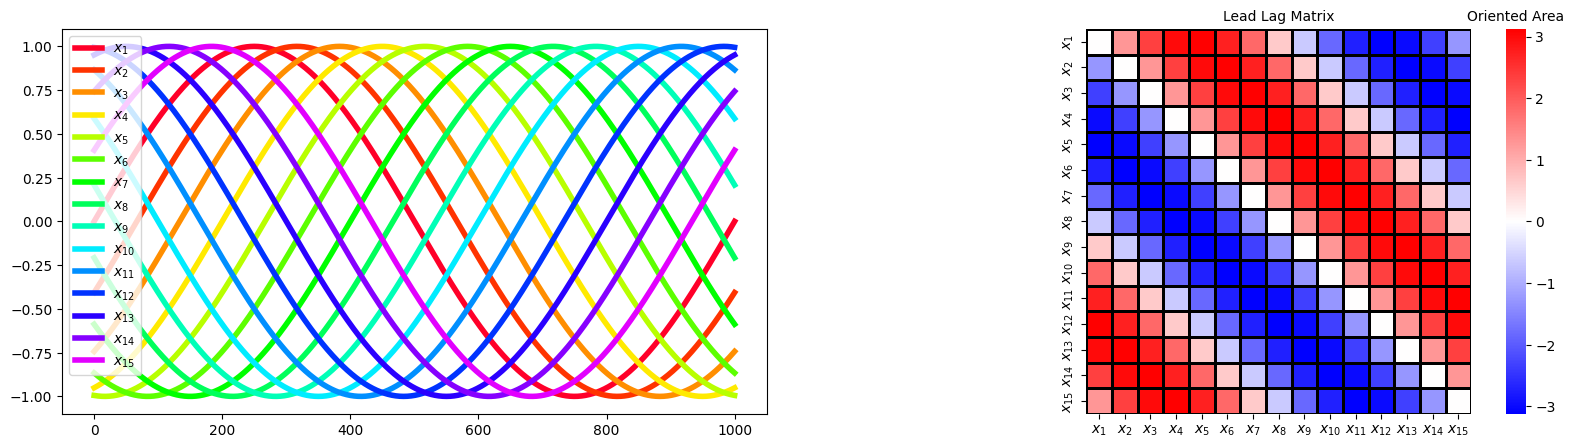

In [2]:
def plot_heatmap(df, ax = None, figsize = (5,5),
                 title='Lead Lag Matrix', title_size=10,
                 xlabel=None, ylabel=None, xlabel_size=10, ylabel_size=10,
                 xticks = True, yticks = True,
                 linecolor='black', linewidths=1.0,
                 annot=False, square=True, cmap='bwr', cbar=True,
                 cbar_title='Oriented Area', cbar_title_size = 10,
                 cbar_location='right', cbar_orientation = None):

  if ax is None:
    ax=plt.subplots(figsize=figsize)[-1]

  sns.heatmap(df, ax=ax, cmap=cmap,linewidths=linewidths, xticklabels=xticks, yticklabels=yticks,
              linecolor=linecolor, square=square, cbar=cbar, annot=annot,
              cbar_kws={'location': cbar_location, 'orientation' : cbar_orientation})

  cbar_ax = ax.figure.axes[-1]
  ax.set_title(title, size=title_size)
  ax.set_xlabel(xlabel, size=xlabel_size)
  ax.set_ylabel(ylabel, size=ylabel_size)
  cbar_ax.set_title(cbar_title, size=cbar_title_size)
  return ax

N,K=15,1000
t=np.linspace(0,1,K+1)
sinusoidal_df=pd.DataFrame(np.array([np.sin(2*np.pi*(t-n/N)) for n in range(N)]).T,
                           columns=['$x_{{{}}}$'.format(n+1) for n in range(N)])
oa = OrientedArea(sinusoidal_df)
lead_lag_df = oa.compute_lead_lag_df()
fig,axs=plt.subplots(1,2,figsize=(20,5))
cmap = plt.get_cmap('gist_rainbow')
axs[0].set_prop_cycle(color=[cmap(n/N) for n in range(N)])
sinusoidal_df.plot(ax=axs[0],linewidth=4.0)
plot_heatmap(lead_lag_df,ax=axs[1])


# Step 2 : Determining the Sequential Order of Time-Series

We now assume $\mathbf x$ is an $N$-dimensional time-series on $I$ satisfying the **Chain of Offsets Model (COOM)**, in which there is an underlying $P$-periodic map $\phi: \mathbb R \rightarrow \mathbb R$ and offsets $c_1 \ , \ \dots \ , \ c_N>0$ and offsets $\alpha_1 \ , \ \dots \ , \ \alpha_N \in [0,P)$ such that $$x_n(t)=c_n \phi(t-\alpha_n)$$ for each $1 \le n \le N.$ In other words, COOM states that the $N$ component time-series of $\mathbf x$ trace a periodic map up to scaling constants and time lags. Assuming COOM, our goal is to determine the **sequential order** of our $N$ time-series, which is the ordering of the offsets i.e. permutation $\sigma: \left \lbrace 1 \ , \ \dots \ , \ N   \right \rbrace \rightarrow \left \lbrace 1 \ , \ \dots \ , \ N  \right \rbrace$ such that $\alpha_{\sigma(1)} \ \le \ \dots \ \le \  \alpha_{\sigma(N)}.$ The lead matrix will come in handy.

**Proposition**: Let $\phi$ be the $P$-periodic map as defined in COOM. Then, the following properties hold.
  * We have $\phi(t) = \sum_{k \in \mathbb Z} \widehat{\phi}_k e^{\frac{2 \pi i k t}{P}},$ where $\widehat{\phi}_k$ is the $k$-th Fourier Coefficient of $\phi.$
  * The lead matrix $\mathbf Q$ corresponding to $\mathbf x$ under COOM has $(m,n)$-th entry equal to $2 \pi c_m c_n \sum_{k \in \mathbb N} k \left|\widehat{\phi}_k \right|^2 \sin \left(\frac{2 \pi k (\alpha_m-\alpha_n)}{P} \right)$ for all $1 \le m,n \le N.$
  * Assume $\phi$ has one harmonic i.e. there exists exactly one $k \in \mathbb N$ for which $\widehat{\phi}_k \ne 0.$ Then the lead matrix $\mathbf Q$ has rank $2$, and its leading eigenvector is of the form $\mathbf v = e^{i \theta} \left(e^{\frac{2 \pi i \alpha_1}P} \ , \ \dots \ , \ e^{\frac{2 \pi i \alpha_N}P} \right)$ for some $\theta>0.$ Furthermore, the sequential order of our $N$ component time-series is a permutation  $\sigma: \left \lbrace 1 \ , \ \dots \ , \ N   \right \rbrace \rightarrow \left \lbrace 1 \ , \ \dots \ , \ N  \right \rbrace$ such that $\text{Arg} \left(v_{\sigma(1)} \right) \le \ \dots \ \le \text{Arg} \left(v_{\sigma(N)} \right),$ where $v_n$ is the $n$-th component of $\mathbf v$ and $\text{Arg}(v_n) \in [0, 2\pi)$ is the principal argument of $v_n.$

So the last statement tells us that when the periodic map $\phi$ in COOM has only one harmonic, then leading eigenvector of the lead matrix contains information about the offsets. In this case, we can recover the sequential order by simply sorting the components of the leading eigenvector according to their respective principal arguments.

Even if $\phi$ were to have more than one harmonic, nothing changes too much as long as it has a dominating harmonic i.e. there exists exactly one $k \in \mathbb N$ such that $\left|\widehat{\phi}_k \right|^2 \gg \sum_{\ell \ne k} \left|\widehat{\phi}_\ell \right|^2.$ The corresponding matrix term $2 \pi c_m c_n k \left|\widehat{\phi}_k \right|^2 \sin \left(\frac{2 \pi k (\alpha_m-\alpha_n)}{P} \right)$ in the series expansion of the lead matrix $\mathbf Q$ will dominate and serve as a best rank $2$ approximation for the lead matrix $\mathbf Q$ in Frobenius Norm. As a result, the leading eigenvector of $\mathbf Q$ will approximate the leading eigenvector of the dominant matrix term in the series expansion of $\mathbf Q.$

## Example

Reconsider the $N$-dimensional sinusoidal time-series $\mathbf x$ on $[0,1]$ in which $x_n(t)=\sin \left (2 \pi \left(t -\frac{n-1}{N} \right) \right)$ for each $1 \le n \le N.$

On one hand, $\mathbf x$ satisfies COOM with $P=1$ and $\phi(t)=\sin(2 \pi t)$ and $\alpha_n= \frac{n-1}{N}.$  We deduce from the explicit values of the offsets that the sequential order is simply the identity permutation on $\left \lbrace 1 \ , \ \dots \ , \ N \right \rbrace.$

On the other hand, we corroborate the sequential order via the leading eigenvector of the lead matrix $\mathbf Q$ corresponding to $\mathbf x.$ Note $\mathbf Q$ is a rank $2$ circulant skew-symmetric matrix with its $n$-th eigenvector $\mathbf v_n =\frac{1}{\sqrt N} \left(1 , e^{\frac{2 \pi i n}{N}} \ , \ \dots \ , e^{\frac{2 \pi i (N-1)}{N}} \right)$ corresponding to its $n$-th eigenvalue $\lambda_n = \pi \sum_{p=1}^N \sin \left(\frac{2 \pi(p-1)}{N} \right) e^{\frac{2 \pi i n (p-1)}{N}}$ for each $1 \le n \le N.$ Furthermore, the dominant eigenvalue is $\lambda_1=\frac{N \pi i}{2}$ and leading eigenvector is $\mathbf v_1.$ The principal argument of the $p$-th component of $\mathbf v_1$ is $\frac{2 \pi (p-1)}{N},$ and so we see the components of $\mathbf v_1$ are already sorted according to their principal arguments. Hence, the sequential order is simply the identity permutation on $\left \lbrace 1 \ , \ \dots \ , \ N \right \rbrace.$

We plot the components (as coordinates in $\mathbb R^2$) of the leading eigenvector corresponding to the discrete lead matrix from before. We also plot the moduli of the $N$ eigenvalues of the discrete lead matrix sorted in descending order.


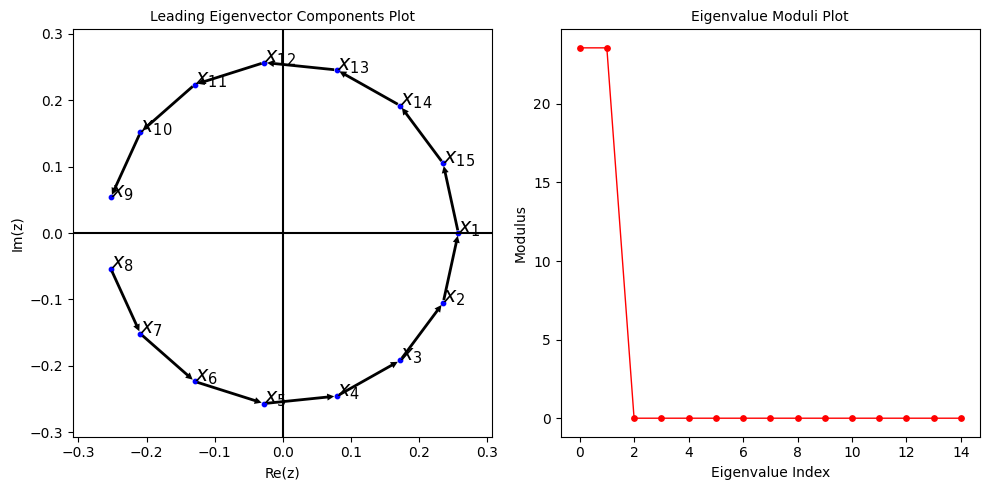

In [3]:
def constellation_plot(v, sequential_order_dict, ax=None, figsize=(5,5),
                       title='Leading Eigenvector Components Plot', title_size=10,
                       xlabel = 'Re(z)', xlabel_size = 10, ylabel = 'Im(z)', ylabel_size=10,
                       plot_xmin = None , plot_xmax = None, plot_ymin = None, plot_ymax = None, xaxis_color='black', yaxis_color= 'black',
                       marker_size = 10, marker_color='blue', annotate_constellations = True, marker_annotation_size=15,
                       include_sequential_order_arrows = False , arrowstyle='simple',
                       arrow_mutation_scale = 10, arrow_linewidth=0.05, arrow_color='black'):


  if ax is None:
    ax=plt.subplots(figsize=figsize)[-1]
      
  sequential_order_indices = list(sequential_order_dict.keys())
  sequential_order_columns = list(sequential_order_dict.values())
  
  x,y = np.real(v) , np.imag(v)
  N=len(v)

  if plot_xmax is None:
    plot_xmax= np.max(np.abs(x)) + 0.1
  if plot_xmin is None:
    plot_xmin = -plot_xmax
  if plot_ymax is None:
    plot_ymax= np.max(np.abs(y)) + 0.1
  if plot_ymin is None:
    plot_ymin = -plot_ymax

  ax.set_title(title, size=title_size)
  ax.scatter(x,y,color=marker_color,s=marker_size)
  ax.set_xlim(plot_xmin , plot_xmax)
  ax.set_ylim(plot_ymin , plot_ymax)
  ax.hlines(0 , plot_xmin , plot_xmax, color=xaxis_color)
  ax.vlines(0 , plot_ymin , plot_ymax, color=yaxis_color)
  ax.set_xlabel(xlabel, size=xlabel_size)
  ax.set_ylabel(ylabel, size=ylabel_size)

  if annotate_constellations:
    for n in range(N):
      text = sequential_order_columns[n]
      coords = (x[sequential_order_indices[n]],y[sequential_order_indices[n]])
      ax.annotate(text=text, xy=coords, size=marker_annotation_size)
  if include_sequential_order_arrows:
    for n in range(N-1):
      head = (x[sequential_order_indices[n+1]],y[sequential_order_indices[n+1]])
      tail = (x[sequential_order_indices[n]],y[sequential_order_indices[n]])
      arrow = patches.FancyArrowPatch(tail, head, mutation_scale=arrow_mutation_scale,
                                      arrowstyle=arrowstyle,
                                      lw=arrow_linewidth,color=arrow_color)
      ax.add_patch(arrow)
  return ax

def eigenvalue_moduli_plot(eigenvalue_moduli, ax=None , figsize=(5,5) ,
                           title='Eigenvalue Moduli Plot' , title_size=10,
                           xlabel='Eigenvalue Index', xlabel_size=10,
                           ylabel = 'Modulus', ylabel_size=10, linewidth=1.0,
                           marker_size=15):
  if ax is None:
    ax = plt.subplots(figsize=figsize)[-1]

  ax.set_title(title, size=title_size)
  ax.set_xlabel(xlabel, size=xlabel_size)
  ax.set_ylabel(ylabel, size=ylabel_size)

  ax.scatter(range(len(eigenvalue_moduli)) , eigenvalue_moduli, s = marker_size , color='red')
  ax.plot(eigenvalue_moduli, linewidth=linewidth, color='red')
  return ax




coom = COOM(lead_lag_df)
eigenvalue_moduli = coom.eigenvalue_moduli
leading_eigenvector,leading_eigenvector_component_phases, sequential_order_dict = coom.compute_sequential_order(0)

fig,axs=plt.subplots(1,2, figsize=(10,5))
constellation_plot(leading_eigenvector, sequential_order_dict ,ax=axs[0],
                   include_sequential_order_arrows=True,
                   arrow_mutation_scale=10,
                   arrow_linewidth=0.01)
eigenvalue_moduli_plot(eigenvalue_moduli, ax=axs[1])
fig.tight_layout()

# Application : Stock Price Analysis

As a practical example, we examine the historical time-series of daily stock (closing) price time-series for $N$ given number of companies in the financial sector.

We collect such data from Yahoo Finance below. Following the standard preprocessing procedures with such time-series, we take the logarithm, detrend, and normalize each stock price time-series, and translate each resulting stock price time-series by the first day stock-price value. To this end, we let $\left \lbrace x_{n, k} \right \rbrace_{k=1}^K$ be the stock price time-series of the $n$-th company, where $x_{n, k}$ is the preprocessed closing price of the $n$-th company at day $k,$ according to the above procedure. We note $k=1$ corresponds to first trading day of $2019$, while $K$ corresponds to the latest, most recent trading day before today (at the time of writin).

We plot our $N$ preprocessed time-series and the corresponding discrete lead matrix.

/var/folders/sf/bz20bv2s5q97ts1n0pwm9zk40000gq/T/ipykernel_13665/2269676002.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_stock_prices_df.fillna(method='ffill',inplace=True)
/var/folders/sf/bz20bv2s5q97ts1n0pwm9zk40000gq/T/ipykernel_13665/2269676002.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_stock_prices_df.fillna(method='bfill',inplace=True)


<Axes: title={'center': 'Lead Lag Matrix'}>

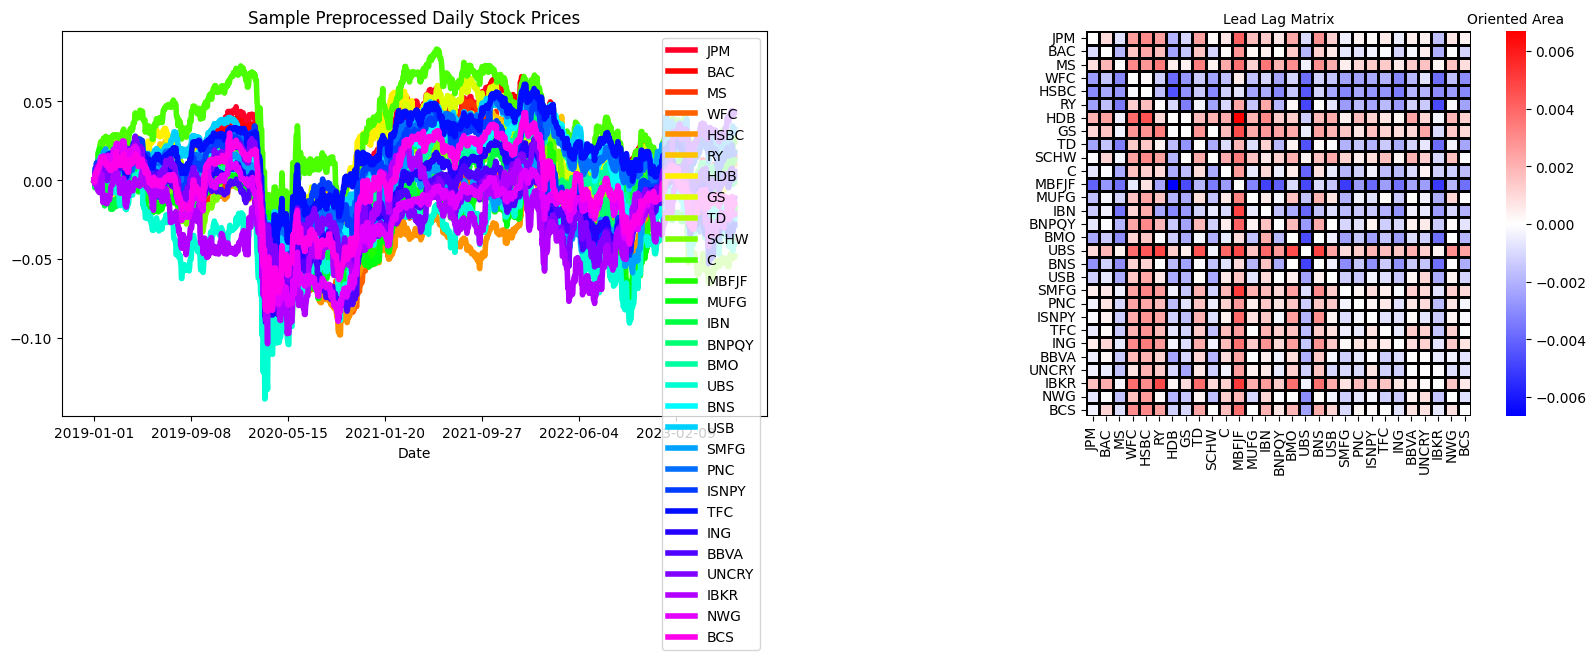

In [4]:
from io import StringIO
import requests
import scipy as sc

def fetch_daily_stock_prices_df(stock_abbrevs,
                                start_date='2010-01-01',
                                end_date ='2023-03-10', update=False):
    directory='data/stocks'
    try:
        os.makedirs(directory)
    except:
        pass
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())
    stock_URL="https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1d&events=history&includeAdjustedClose=true"
    daily_stock_prices_dfs= []
    for stock_abbrev in stock_abbrevs:
        file_path = "{}/{}.csv".format(directory,stock_abbrev)
        df=pd.DataFrame()

        update_col = False
        if os.path.exists(file_path):
            df=pd.read_csv(file_path, index_col=0)
        else:
            update_col = True

        if update or update_col:

            try:
                headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'}
                df=pd.read_csv(StringIO(requests.get(stock_URL.format(stock_abbrev, start_timestamp, end_timestamp),
                                                     headers = headers).text))
                df.set_index("Date", inplace=True)
                df.to_csv(file_path)
                print("SUCCESSFULLY SAVED {}".format(stock_abbrev))
            except:
                print("FAILED TO SAVE {}".format(stock_abbrev))
                df=pd.DataFrame()
                continue


        daily_stock_prices_dfs.append(df[['Close']].rename(columns={'Close' : stock_abbrev}))

    daily_stock_prices_df=pd.DataFrame(index=pd.date_range(start_date , end_date, freq='D').strftime("%Y-%m-%d"))
    daily_stock_prices_df.index.rename("Date",inplace=True)

    daily_stock_prices_df = pd.concat([daily_stock_prices_df]+daily_stock_prices_dfs,axis=1)
    daily_stock_prices_df.fillna(method='ffill',inplace=True)
    daily_stock_prices_df.fillna(method='bfill',inplace=True)

    return daily_stock_prices_df.loc[start_date : end_date]



stock_abbrevs=['JPM','BAC','MS','WFC','HSBC','RY','HDB','GS','TD','SCHW',
               'C','MBFJF','MUFG','IBN','BNPQY','BMO','UBS','BNS','USB',
               'SMFG','PNC','ISNPY','TFC','ING','BBVA','UNCRY','IBKR',
               'NWG','BCS']


daily_stock_prices_df =fetch_daily_stock_prices_df(stock_abbrevs,
                                                   start_date='2019-01-01',
                                                   end_date='2023-07-10',update=False)

for col in daily_stock_prices_df.columns:
    daily_stock_prices_df[col]=sc.signal.detrend(np.log(daily_stock_prices_df[col].values))
    norm=np.linalg.norm(daily_stock_prices_df[col].fillna(0),2)
    daily_stock_prices_df[col] = daily_stock_prices_df[col]/norm

daily_stock_prices_df -=daily_stock_prices_df.iloc[0]
N=len(daily_stock_prices_df.columns)
fig,axs=plt.subplots(1,2,figsize=(20,5))
cmap = plt.get_cmap('gist_rainbow')
axs[0].set_prop_cycle(color=[cmap(n/N) for n in range(N)])
daily_stock_prices_df.plot(ax=axs[0], linewidth=4.0, title='Sample Preprocessed Daily Stock Prices')
OA=OrientedArea(daily_stock_prices_df)
lead_lag_df = OA.compute_lead_lag_df()
plot_heatmap(lead_lag_df,ax=axs[1])

We also plot the leading eigenvector components and the lead matrix eigenvalue moduli sorted in descending order.

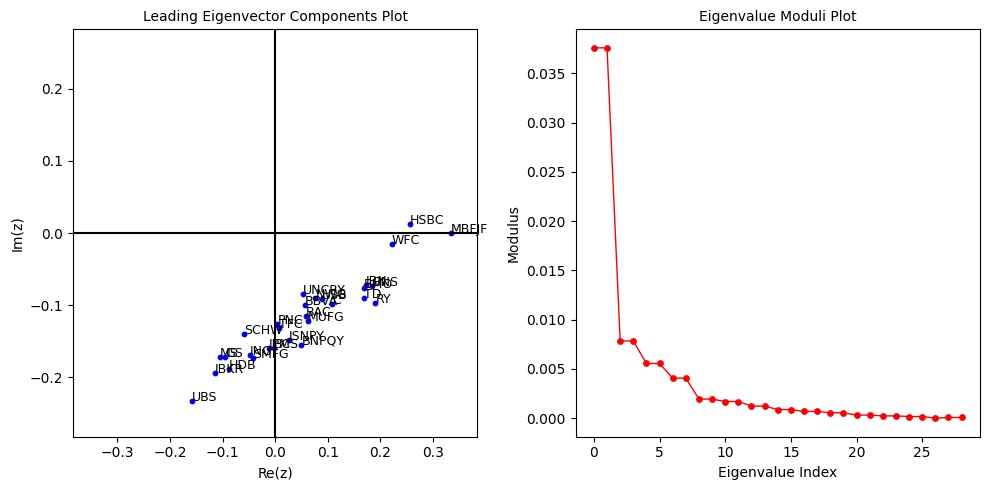

In [5]:
coom = COOM(lead_lag_df)
eigenvalue_moduli = coom.eigenvalue_moduli
leading_eigenvector,leading_eigenvector_component_phases, sequential_order_dict = coom.compute_sequential_order(0)

fig,axs=plt.subplots(1,2, figsize=(10,5))
constellation_plot(leading_eigenvector, sequential_order_dict,ax=axs[0],
                   include_sequential_order_arrows=False,
                   marker_annotation_size=9,
                   arrow_mutation_scale=10,
                   arrow_linewidth=0.01)
eigenvalue_moduli_plot(eigenvalue_moduli, ax=axs[1])
fig.tight_layout()

## Accumulated Oriented Areas

In practical applications, given an $N$-dimensional time-series $\mathbf x$ on $I=[a,b]$, it is useful to look at the matrix-valued function $s \mapsto \mathbf Q(s),$ where $\mathbf Q(s)$ is the lead matrix corresponding to $\mathbf x$ restricted to $[a,s]$ for each $s \in I.$ In particular, for fixed $1 \le m,n \le N,$ the map $s \mapsto Q_{m,n}(s)$ is the **accumulated oriented area** corresponding to the component time-series $x_m$ and $x_n.$ The accumulated oriented area reveals the evolution leader follower relationship between $x_m$ and $x_n$ throughout time. We plot several accumulated oriented areas.

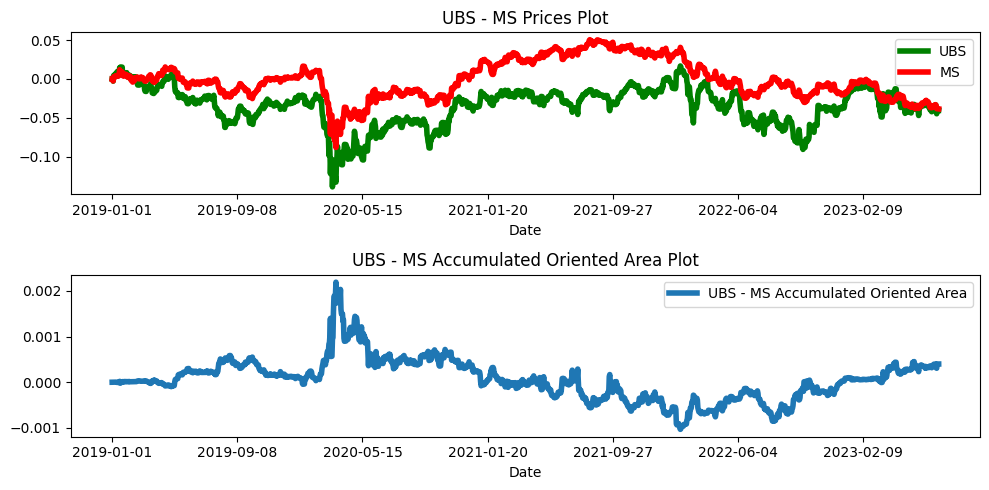

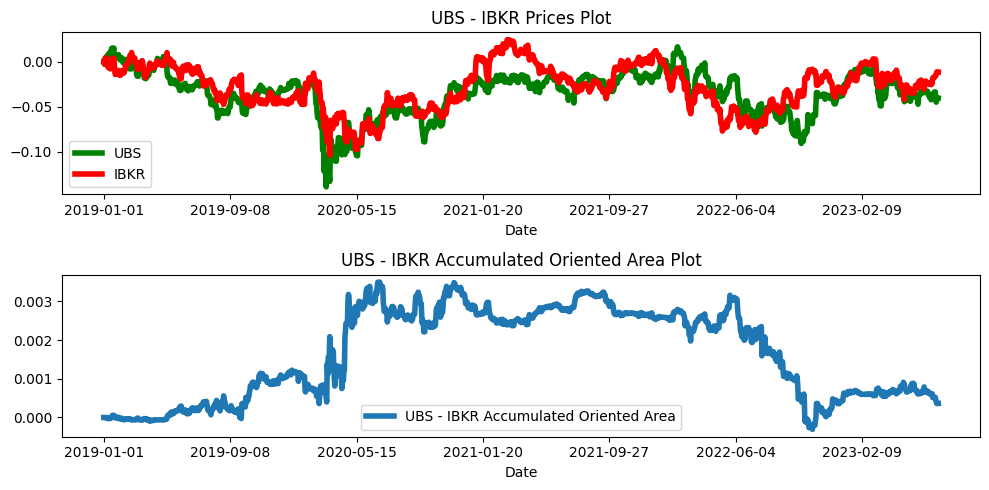

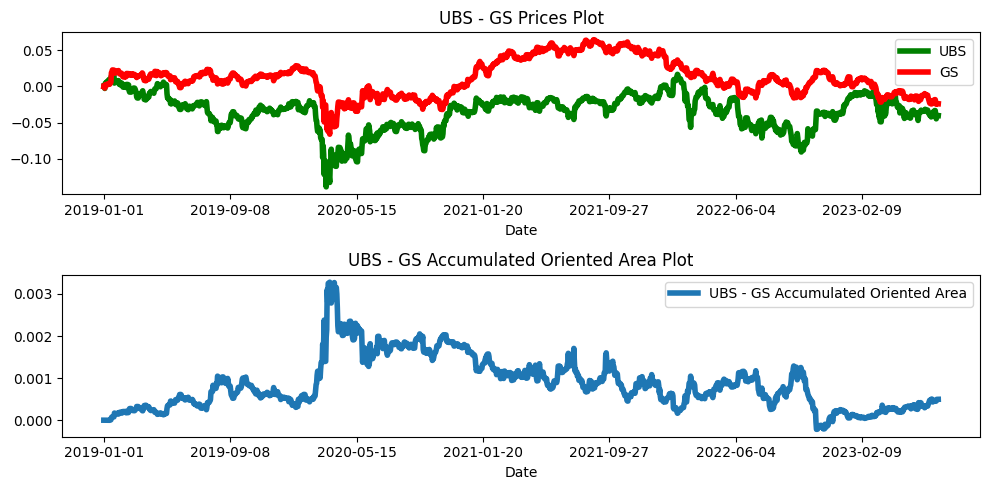

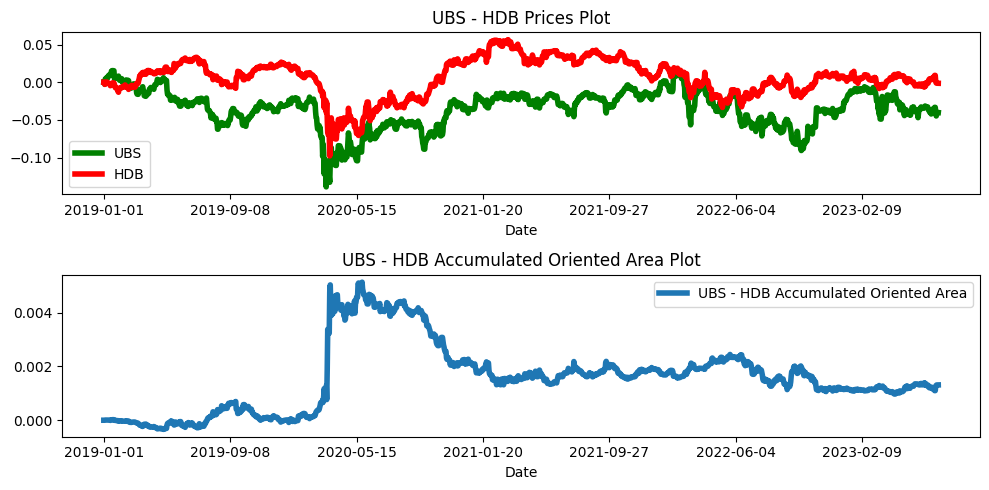

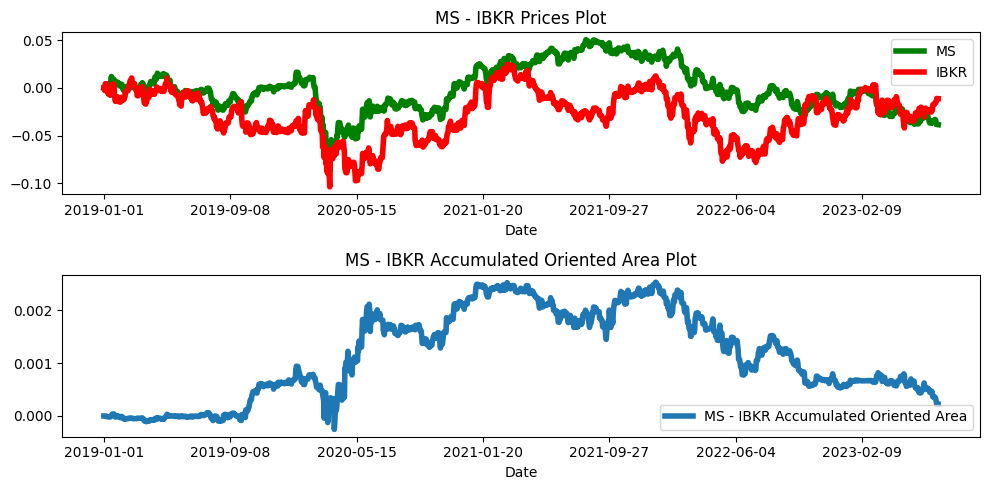

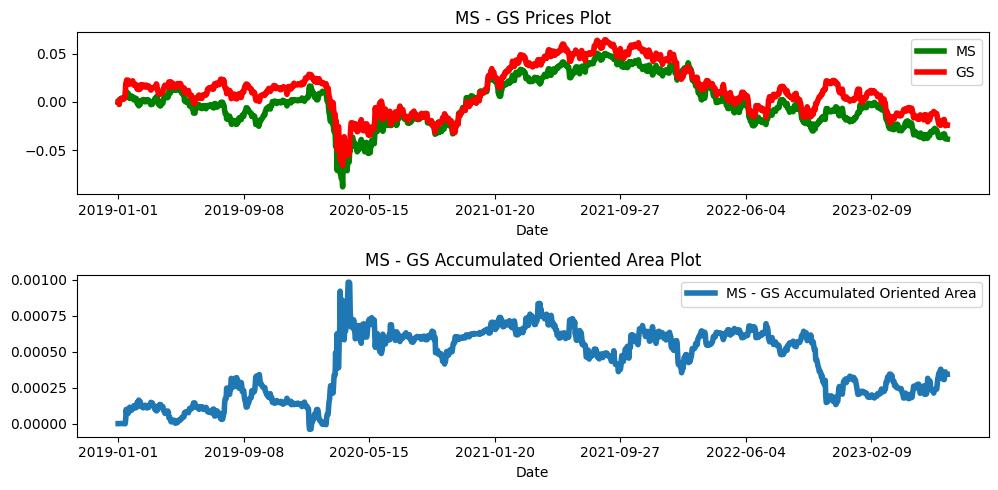

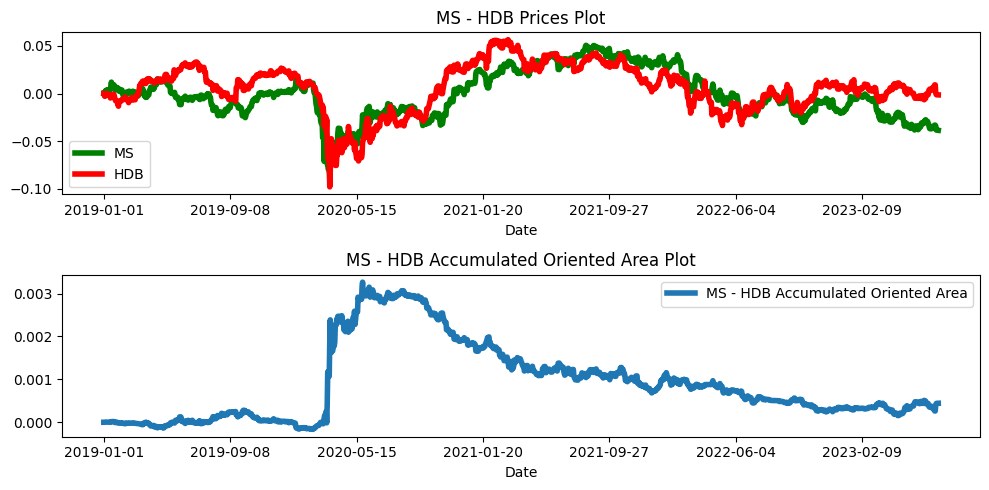

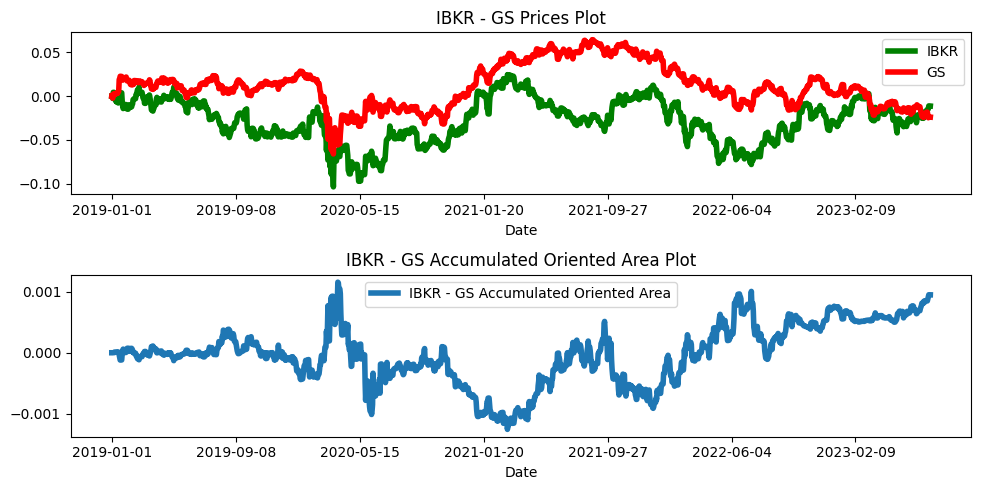

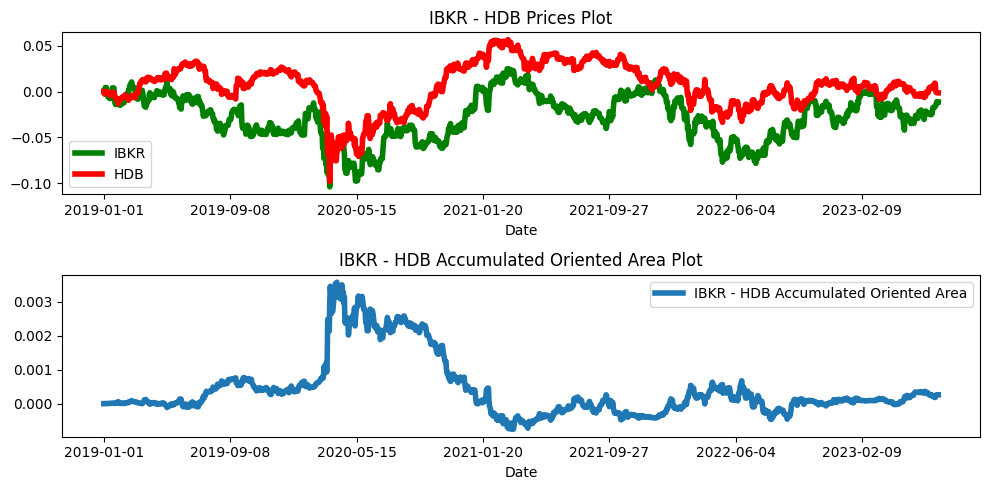

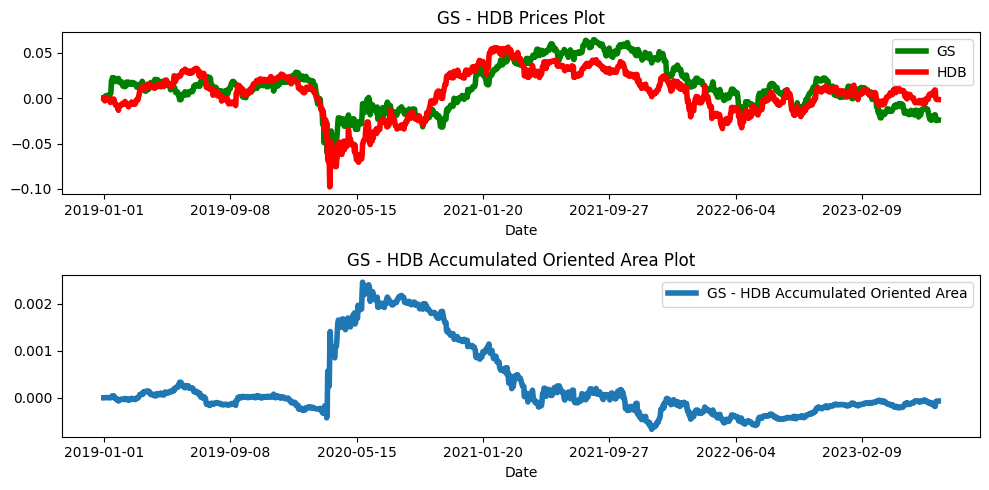

In [6]:
directory ='data/stocks/accumulatedorientedareas'
update=False
try:
  os.makedirs(directory)
except:
  pass
sequential_order_columns = list(sequential_order_dict.values())

for i in range(10):
  for j in range(i+1,5):
    
    leader, follower = sequential_order_columns[i] , sequential_order_columns[j]
    file_path = "{}/{}_{}.csv".format(directory, leader, follower)
    
    if os.path.exists(file_path):
      pairwise_accumulated_oriented_area_df = pd.read_csv(file_path, index_col = 0)
    else:
      update=True
    if update:
      print("SAVED ACCUMULATED ORIENTED AREA FOR {} - {} ...".format(leader,follower))
      pairwise_accumulated_oriented_area_df = OA.compute_pairwise_accumulated_oriented_area_df(leader,follower)
      pairwise_accumulated_oriented_area_df.to_csv(file_path)
        
    fig,axs=plt.subplots(2,1, figsize=(10,5))
    daily_stock_prices_df[[leader , follower]].plot(ax=axs[0],color=['green','red'], linewidth=4.0, title = "{} - {} Prices Plot".format(leader, follower))
    pairwise_accumulated_oriented_area_df.plot(ax=axs[1], title="{} - {} Accumulated Oriented Area Plot".format(leader, follower), linewidth=4.0)
    fig.tight_layout()


      
